In [1]:
from sys import path
from constants import PROJECT_DIR
path.insert(1, PROJECT_DIR)

from master.manager.stage_manager import StageManager
from base_utils import path_join
from constants import DEFAULT_PARAM_TEMPLATE, MASTER_DATABASE_DIR

import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000

In [2]:
def stage_stats(stage):
    stage_manager = StageManager(DEFAULT_PARAM_TEMPLATE)
    stage_info = stage_manager.get_stage_info(stage)
    eval_results = stage_info["eval_results"]
    winrates = {model_id:[eval_results[model_id][opp_id]["winrate"] for opp_id in eval_results[model_id]] for model_id in eval_results}
    model_ids = list(winrates.keys())
    avg_winrates = [sum(winrates[model_id])/len(winrates[model_id]) for model_id in winrates]
    parent, policy, learning_rate, gamma, gae_lambda = zip(*read_models_info(stage, model_ids))
    data = zip(model_ids, avg_winrates, parent, policy, learning_rate, gamma, gae_lambda)
    scores_df = pd.DataFrame(data, columns=["model_id", "score", "parent", "policy", "lr", "gamma", "gae_lambda"])
    return scores_df

def read_models_info(stage, models, database=MASTER_DATABASE_DIR):
    data = []
    for model in models:
        model_path = path_join(database, stage, model)
        with open(path_join(model_path, "info.json")) as f:
            model_info = eval(f.read())
        parent = model_info["parents"][-1] if len(model_info["parents"]) > 0 else None
        data.append([parent, *model_info["train_params"].values()])
    return data

def stage_best_stats(stage):
    stage_manager = StageManager(DEFAULT_PARAM_TEMPLATE)
    stage_info = stage_manager.get_stage_info(stage)
    scores_df = stage_stats(stage)
    best_models = stage_info["best_models"]
    mask = [model_id in best_models for model_id in scores_df["model_id"]]
    return scores_df.loc[mask].sort_values("score", ascending=False).reset_index(drop=True)

In [3]:
def get_all_best_stats(stages):
    df = pd.DataFrame([], columns=["model_id", "score", "parent", "policy", "lr", "gamma", "gae_lambda", "stage"])
    for stage in stages:
        stage_df = stage_best_stats(stage)
        stage_df["stage"] = stage
        df = df.append(stage_df).reset_index(drop=True)

    df.reset_index(drop=True)
    return df

In [4]:
max_stage = 51
stages = [f"stage_{i}" for i in range(1, max_stage+1)]

In [5]:
stage_best_stats(stages[-1])

,model_id,score,parent,policy,lr,gamma,gae_lambda
0,13267,0.533333,38600,agent1,0.0001,0.995,0.95


In [7]:
df = get_all_best_stats(stages)

ValueError: not enough values to unpack (expected 5, got 0)

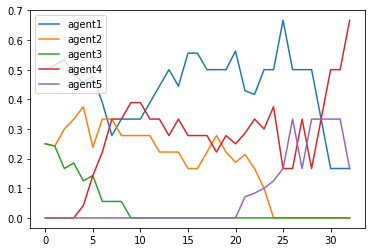

In [6]:
def policy_dist(filtered_stages, df):
    mask = [stage in filtered_stages for stage in df["stage"]]
    return df.loc[mask]["policy"].value_counts()

def plot_policies(max_stage, method="cumulative", avg_range=3):
    if method == "cumulative":
        arg = [[f"stage_{i}" for i in range(n, max_stage+1)] for n in range(13, max_stage)]
    elif method == "single":
        arg = [f"stage_{i}" for i in range(13, max_stage+1)]
    elif method == "moving_avg":
        arg = [[f"stage_{i}" for i in range(n, n+avg_range)] for n in range(13, max_stage-avg_range+1)]
    all_stages = [f"stage_{i}" for i in range(13, max_stage+1)]
    df = get_all_best_stats(all_stages)
    agent_keys = [f"agent{i}" for i in range(1, 6)]
    data = []
    for a in arg:
        dist = policy_dist(a, df)
        dist = dist / sum(dist)
        for key in agent_keys:
            if key not in dist:
                dist[key] = 0
        dist = [dist[key] for key in agent_keys]
        data.append(dist)
    plt.plot(data)
    plt.legend(agent_keys)
    plt.show()

plot_policies(max_stage, method="moving_avg", avg_range=6)